In [1]:
import ROOT

Welcome to JupyROOT 6.26/00


In [1]:
# import packages
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os
import sys
import hist

# set cms plot style
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from setting import setting

In [2]:
#config_path = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL_alphavalidate_110to135.yml"
import yaml
config_path = "/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16.yml"
with open( config_path) as f:
    config = yaml.safe_load(f)

    
    
#####################
#make cut
def make_cut(selection,arr):
    r'''
    input: selection, arr as ak.Aarry()
    output: cuted arr with selection
    '''
    cut  = ak.numexpr.evaluate(selection,arr)
    return arr[cut]

In [4]:
year = '2018'

#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','WWTo1L1Nu2Q','tZq','ZZTo2L2Nu','WZTo1L1Nu2Q','ggh1000','ggh500','sig','ggh2000']
#samples = ['DY_pt50To100','DY_pt100To250','DY_pt250To400','DY_pt400To650','DY_pt650ToInf','TTTo2L2Nu','WWTo2L2Nu','WZTo2Q2L','ZZTo2Q2L','tZq','ggh1000','sig']
samples = ['ggh500','ggh1000','ggh2500']
arr = {}
sumweight = {}
for sample in samples:
    arr[sample] = uproot.lazy([f"{setting().fileset[year][sample][0]}:passedEvents"])
    
    f = uproot.open(setting().fileset[year][sample][0])['sumWeights']
    sumweight[sample] = (f.to_boost()).sum()
    f.close()

In [5]:
#make cut 
arr_cut_merged = {}
selection_merged = config['cut']['merged']['net']['SR']['2lep']['all']
for sample in samples:
    arr_cut_merged[sample] = make_cut(selection_merged,arr[sample])

arr_cut_resolved = {}
selection_resolved = config['cut']['resolved']['SR']['2lep']['all']
for sample in samples:
    arr_cut_resolved[sample] = make_cut(selection_resolved,arr[sample])

In [5]:
arr_cut['ggh1000'].fields

['pConst_GG_SIG_ghg2_1_ghz1_1_JHUGen',
 'p_GG_SIG_ghg2_1_ghz1_1_JHUGen',
 'pConst_GG_SIG_kappaTopBot_1_ghz1_1_MCFM',
 'p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM',
 'pConst_ZJJ_BKG_MCFM',
 'p_ZJJ_BKG_MCFM',
 'pAux_JVBF_SIG_ghv1_1_JHUGen',
 'p_JVBF_SIG_ghv1_1_JHUGen',
 'pConst_JJVBF_SIG_ghv1_1_JHUGen',
 'p_JJVBF_SIG_ghv1_1_JHUGen',
 'p_JJVBF_SIG_ghv1prime2_1E4_JHUGen',
 'p_JJVBF_SIG_ghv2_1_JHUGen',
 'p_JJVBF_SIG_ghv4_1_JHUGen',
 'p_JJVBF_SIG_ghza1prime2_1E4_JHUGen',
 'p_JJVBF_SIG_ghv1_1_ghv1prime2_1E4_JHUGen',
 'p_JJVBF_SIG_ghv1_1_ghv2_1_JHUGen',
 'p_JJVBF_SIG_ghv1_1_ghv4_1_JHUGen',
 'pConst_JQCD_SIG_ghg2_1_JHUGen',
 'p_JQCD_SIG_ghg2_1_JHUGen',
 'pConst_JJQCD_SIG_ghg2_1_JHUGen',
 'p_JJQCD_SIG_ghg2_1_JHUGen',
 'p_Gen_CPStoBWPropRewgt',
 'lep_1_pt',
 'lep_1_phi',
 'lep_2_pt',
 'lep_1_eta',
 'lep_2_eta',
 'lep_2_phi',
 'Nleptons',
 'Ntightleptons',
 'GENlep_DR',
 'n_addtional_looselep',
 'mass2jet',
 'mass2jet_mass_bais',
 'mass2jet_up',
 'mass2jet_dn',
 'pt2jet',
 'pt2jet_mass_bais',
 'pt2jet_up'

In [6]:
arr_cut['ggh1000'].pConst_GG_SIG_kappaTopBot_1_ghz1_1_MCFM

<Array [1.07e+07, 1.01e+07, ... 1.28e+07] type='51403 * float32'>

(array([20849.,  8325.,  6143.,  4990.,  4200.,  2899.,  1326.,  1017.,
          938.,   716.]),
 array([0.4137508 , 0.47228688, 0.530823  , 0.5893591 , 0.6478952 ,
        0.70643127, 0.7649674 , 0.8235035 , 0.88203955, 0.94057566,
        0.9991118 ], dtype=float32),
 <BarContainer object of 10 artists>)

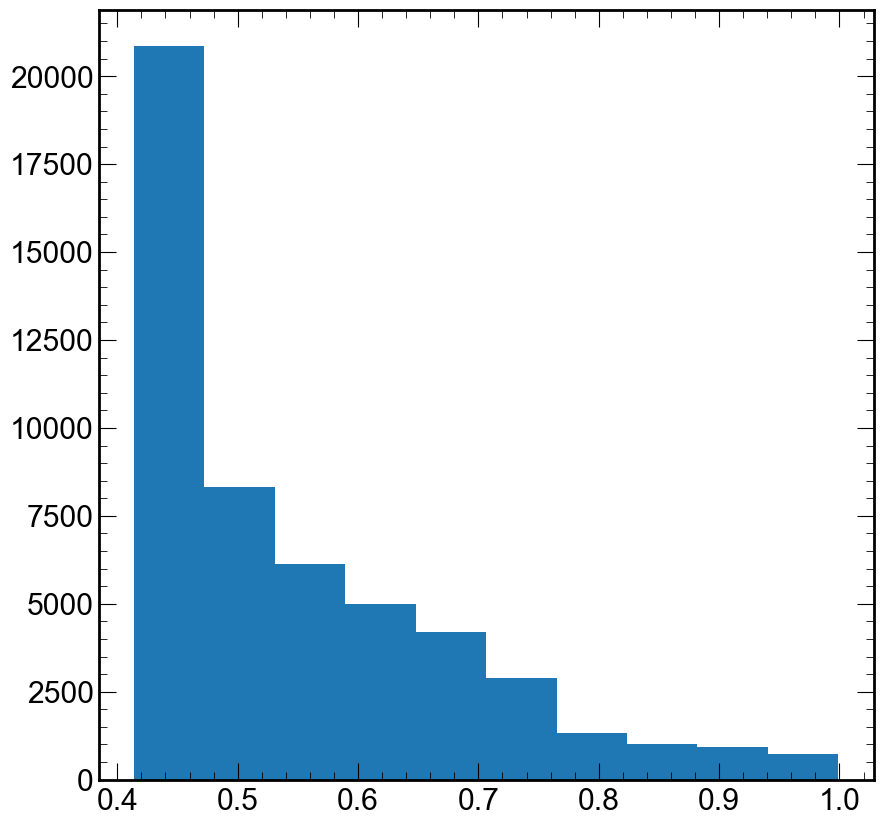

In [8]:
plt.hist(arr_cut['ggh1000'].p_Gen_CPStoBWPropRewgt)

In [6]:
#fill histo
#check varbs
varb = 'mass2lj' #
#fill hist
bins = 400; start = 0; stop = 4000
lumi = config['lumi']['2018']
h = {}
h_raw = {}
for sample in samples:
    xsec = config['samples_inf'][sample][1]
    h[sample] = hist.Hist(hist.axis.Regular(bins,start,stop))
    h[sample].fill(
        #arr_cut_resolved[sample]['mass2l2jet'] - arr_cut_resolved[sample]['GEN_H1_mass'],
        arr_cut_resolved[sample]['mass2l2jet'],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_resolved[sample])
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_resolved[sample])
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_resolved[sample])
    )

    h[sample].fill(
        #arr_cut_merged[sample]['mass2lj']-arr_cut_merged[sample]['GEN_H1_mass'],
        arr_cut_merged[sample]['mass2lj'],
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_merged[sample])
        #weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_merged[sample])
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000*p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM*p_Gen_CPStoBWPropRewgt/{sumweight[sample]}',arr_cut_merged[sample])
    )

    # fill raw hist with remove p_GG_SIG_kappaTopBot_1_ghz1_1_MCFM*p_Gen_CPStoBWPropRewgt weight
    h_raw[sample] = hist.Hist(hist.axis.Regular(bins,start,stop))
    h_raw[sample].fill(
        arr_cut_merged[sample]['mass2lj'],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_merged[sample])
    )

    h_raw[sample].fill(
        arr_cut_resolved[sample]['mass2l2jet'],
        weight = ak.numexpr.evaluate(f'EventWeight*{lumi}*1000/{sumweight[sample]}',arr_cut_resolved[sample])
    )
    

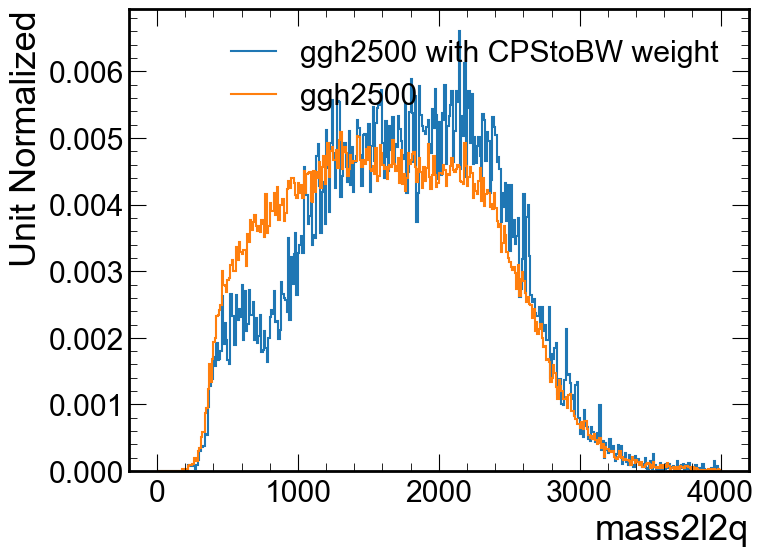

In [11]:
# draw comparison plot: h vs h_raw
plt.figure(figsize=(8,6))
sample = 'ggh2500'
h[f'{sample}'].plot1d(density = True,label = f'{sample} with CPStoBW weight')
h_raw[f'{sample}'].plot1d(density = True,label = f'{sample}')
#h['ggh500'].plot1d(density = True,label = 'ggh500 with CPStoBW weight')
##h_raw['ggh1000'].plot1d(density = True,label = 'ggh1000')
#set x and y axis title
plt.xlabel('mass2l2q')
plt.ylabel('Unit Normalized')
plt.legend()

In [7]:
plt.close()

In [8]:
#save hist in root file
with uproot.recreate(f'./histo_ggh500.root') as f:
    for sample in samples:
        f[f'{sample}'] = h[sample]

In [41]:
#tot eff
print(len(arr['ggh1000'].GEN_H1_mass))
print(len(arr_cut_resolved['ggh1000'].GEN_H1_mass))
print(len(arr_cut_merged['ggh1000'].GEN_H1_mass))
print('eff = {}'.format((len(arr_cut_resolved['ggh1000'].GEN_H1_mass) + len(arr_cut_merged['ggh1000'].GEN_H1_mass))/len(arr['ggh1000'].GEN_H1_mass)))

139912
9454
51403
eff = 0.43496626450912
